# IMMC 2020: With Variable Heuristic and Proper Product List
### Importing Modules and Data

In [53]:
import pandas as pd
import copy
import re
import random
import math, statistics
import numpy as np
import gc
import matplotlib.pyplot as plt
from pprint import pprint

median_income = 9733/365
loss_aversion_coefficient = 2
max_shelf_capacity = 150
max_shopper_capacity = 300
units_per_object = 1
max_pdt_per_shelf = 3
pdts_per_shopper = 3
crowd_avoidance = 0.5
mean_shopper_size=50 #mean size of shopper

pdt_csv_data = pd.read_csv("StoreData_IMMC_CSV.csv")
print(pdt_csv_data.head())

          department product_category       product_type     brand  \
0    TV&Home Theater   TVS 30" to 45"    1080p LED Smart  Brand BB   
1  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand A   
2  Computers&Tablets          Laptops  2-in-1 Chromebook  Brand BB   
3  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand G   
4  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand P   

                                                name  initial_price  \
0                 40" 1080p Smart LED HDTV, 5 Series         259.99   
1  2-in-1 11.6" Touch-Screen Chromebook, Intel Ce...         279.99   
2  2-in-1 12.2" Touch-Screen Chromebook, Intel Ce...         449.00   
3  2-in-1 14" Touch-Screen Chromebook, Intel Core...         549.00   
4  2-in-1 14" Touch-Screen Chromebook, Intel Core...         599.00   

   discounted_price  qty  customer_rating  brand_rating  percentage_usage  \
0            179.99    8              4.7      4.623810              0.95  

In [54]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

## Determining the Popularity of Product
### Impact of Discount on Popularity

In [55]:
# Traditional Econs Approach
def q1_over_q0(p0, p1, percentage_usage):
    x = (p0 - p1)*(percentage_usage/median_income) 
    return (math.exp(x))

# Behavioural Econs Approach
def prospect_utility(x):
    if x > 0:
        return(math.log(x+1))
    else:
        return(-loss_aversion_coefficient * math.log(-x + 1))

def increase_utility(p0, p1):
    return(prospect_utility(p0 - p1))

# Helper Variables
max_increase_utility = increase_utility(3329.99, 2199.99)
min_increase_utility = 0
max_q1_over_q0 = q1_over_q0(3329.99, 2199.99, 1)
min_q1_over_qo = 1

# Combined Effect [Between 0 and 1]
def popularity_due_to_discount(p0, p1, percentage_usage):
    traditional_econs_adjusted = (q1_over_q0(p0, p1, percentage_usage)-min_q1_over_qo)/max_q1_over_q0
    behavioural_econs_adjusted = (increase_utility(p0, p1)-min_increase_utility)/max_increase_utility

    total_adjusted = statistics.mean([traditional_econs_adjusted, behavioural_econs_adjusted])
    return(total_adjusted)

### Effect of Loss Adversion on Popularity

In [56]:
# [Between 0 and 1]
def popularity_due_to_loss_aversion(qty):
    return(math.exp(-qty/loss_aversion_coefficient))

### Effects of Saliency Bias on Popularity (TO DO)

In [57]:
def popularity_due_to_saliency_bias(size, qty):
    return sigmoid(size*qty)

### Effects of Ratings on Popularity

In [58]:
# [Between 0 and 1]
def popularity_due_to_rating(pdt_rating, brand_rating):
    raw_brand = (0.8*pdt_rating + 0.2*brand_rating)
    return(raw_brand/5)

## Creating Product Class and List

In [59]:
class product:
    # Popularity Coefficients
    pop_loss_adversion_coefficient = 0.44
    pop_saliency_coefficient = 0.6
    pop_rating_coefficient = 0.5
    
    
    # Raw Data
    def __init__(self, index, name, department, product_category, product_type, brand, initial_price, discounted_price, qty, customer_rating, brand_rating=5, percentage_usage=0.5, size=20):
        self.name = name
        self.index = index
        self.department = department
        self.product_category = product_category
        self.product_type = product_type
        self.brand = brand
        self.initial_price = initial_price
        self.discounted_price = discounted_price
        self.qty = qty
        self.customer_rating = customer_rating
        self.brand_rating = brand_rating
        self.percentage_usage = percentage_usage
        self.size = size
        
        self.popularity = 0
    
    # Processed Data
    
    def set_popularity(self):
        discount_factor = popularity_due_to_discount(self.initial_price, self.discounted_price, self.percentage_usage)
        loss_adversion_factor = popularity_due_to_loss_aversion(self.qty)
        saliency_factor = popularity_due_to_saliency_bias(self.size, self.qty)
        rating_factor = popularity_due_to_rating(self.customer_rating, self.brand_rating)
        
        initial_popularity = self.pop_loss_adversion_coefficient*loss_adversion_factor + self.pop_saliency_coefficient*saliency_factor + self.pop_rating_coefficient*rating_factor
        self.popularity = sigmoid(initial_popularity + discount_factor)
        
        
        

In [60]:
# Populating the Product List
pdt_list = []
pdt_counter = 0
for index, row in pdt_csv_data.iterrows():
    
    total_qty = row["qty"]
    unit_size = row["index_size"]
    while True:
        
        cur_qty = min(min(int(max_shelf_capacity/unit_size), total_qty), units_per_object)
        print("index", index, "department", row["department"], "qty", cur_qty, "net_size", cur_qty*unit_size)
        total_qty -= cur_qty
        
        cur_pdt = product(index, row["name"], row["department"], row["product_category"], row["product_type"], row["brand"], row["initial_price"], row["discounted_price"], cur_qty, row["customer_rating"], size=unit_size, brand_rating=row["brand_rating"], percentage_usage=row["percentage_usage"])
        cur_pdt.set_popularity()
        
        pdt_counter += 1
        pdt_list.append(cur_pdt)
        
        if total_qty <=0:
            break

print("pdt_list len", len(pdt_list))
print("Number of products", pdt_counter)

index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_si

index 14 department TV&Home Theater qty 1 net_size 3.192511117
index 14 department TV&Home Theater qty 1 net_size 3.192511117
index 15 department TV&Home Theater qty 1 net_size 3.192511117
index 15 department TV&Home Theater qty 1 net_size 3.192511117
index 15 department TV&Home Theater qty 1 net_size 3.192511117
index 15 department TV&Home Theater qty 1 net_size 3.192511117
index 15 department TV&Home Theater qty 1 net_size 3.192511117
index 15 department TV&Home Theater qty 1 net_size 3.192511117
index 15 department TV&Home Theater qty 1 net_size 3.192511117
index 15 department TV&Home Theater qty 1 net_size 3.192511117
index 16 department TV&Home Theater qty 1 net_size 3.192511117
index 16 department TV&Home Theater qty 1 net_size 3.192511117
index 16 department TV&Home Theater qty 1 net_size 3.192511117
index 16 department TV&Home Theater qty 1 net_size 3.192511117
index 16 department TV&Home Theater qty 1 net_size 3.192511117
index 16 department TV&Home Theater qty 1 net_size 3.19

index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 31 department TV&Home Theater qty 1 net_size 4.957578881
index 32 department TV&Home Theater qty 1 net_size 4.957578881
index 32 department TV&Home Theater qty 1 net_size 4.957578881
index 32 department TV&Home Theater qty 1 net_size 4.957578881
index 32 department TV&Home Theater qty 1 net_size 4.957578881
index 32 department TV&Home Theater qty 1 net_size 4.957578881
index 32 department TV&Home Theater qty 1 net_size 4.95

index 43 department Computers&Tablets qty 1 net_size 1.088366056
index 43 department Computers&Tablets qty 1 net_size 1.088366056
index 43 department Computers&Tablets qty 1 net_size 1.088366056
index 43 department Computers&Tablets qty 1 net_size 1.088366056
index 43 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Compu

index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 55 department Cameras qty 1 net_size 0.05161575841
index 56 department Cameras qty 1 net_size 0.05161575841
index 56 department Cameras qty 1 net_size 0.05161575841
index 56 department Cameras qty

index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 69 department Video Gaming qty 1 net_size 1.03854729
index 70 department Computers&Tablets qty 1 net_size 0.8888424743000001
index 70 department Computers&Tablets qty 1

index 88 department Cell Phones qty 1 net_size 0.008220287406
index 88 department Cell Phones qty 1 net_size 0.008220287406
index 88 department Cell Phones qty 1 net_size 0.008220287406
index 88 department Cell Phones qty 1 net_size 0.008220287406
index 88 department Cell Phones qty 1 net_size 0.008220287406
index 88 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89 department Cell Phones qty 1 net_size 0.008220287406
index 89

index 107 department Appliances qty 1 net_size 36.37530261
index 107 department Appliances qty 1 net_size 36.37530261
index 107 department Appliances qty 1 net_size 36.37530261
index 107 department Appliances qty 1 net_size 36.37530261
index 108 department Appliances qty 1 net_size 36.37530261
index 108 department Appliances qty 1 net_size 36.37530261
index 108 department Appliances qty 1 net_size 36.37530261
index 108 department Appliances qty 1 net_size 36.37530261
index 108 department Appliances qty 1 net_size 36.37530261
index 108 department Appliances qty 1 net_size 36.37530261
index 108 department Appliances qty 1 net_size 36.37530261
index 108 department Appliances qty 1 net_size 36.37530261
index 109 department Appliances qty 1 net_size 36.37530261
index 109 department Appliances qty 1 net_size 36.37530261
index 109 department Appliances qty 1 net_size 36.37530261
index 109 department Appliances qty 1 net_size 36.37530261
index 109 department Appliances qty 1 net_size 36.375302

index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 

In [61]:
department_popularities = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
department_qty = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
for pdt in pdt_list:
    department_popularities[pdt.department]+= pdt.popularity*pdt.qty
    department_qty[pdt.department]+= pdt.qty

for department, total_pop in department_popularities.items():
    print("Department:", department, "Average Popularity", total_pop/department_qty[department])
    
    
print("--------")
total_objects = 0
for department, total_pop in department_popularities.items():
    number_of_objects = 0
    for pdt in pdt_list:
        if pdt.department == department:
            number_of_objects += 1
    total_objects += number_of_objects
    print("Department:", department, "Number of Objects", number_of_objects)
    
print("Total Number of Objects", total_objects)

Department: Appliances Average Popularity 0.8389350550900967
Department: Audio Average Popularity 0.7909613754768059
Department: Cameras Average Popularity 0.8028821374113138
Department: Cell Phones Average Popularity 0.7798840389861017
Department: Computers&Tablets Average Popularity 0.814878007267299
Department: TV&Home Theater Average Popularity 0.8321277481983057
Department: Video Gaming Average Popularity 0.8275033824709389
--------
Department: Appliances Number of Objects 257
Department: Audio Number of Objects 50
Department: Cameras Number of Objects 165
Department: Cell Phones Number of Objects 55
Department: Computers&Tablets Number of Objects 444
Department: TV&Home Theater Number of Objects 383
Department: Video Gaming Number of Objects 181
Total Number of Objects 1535


In [62]:
pdt_list[4].index

0

## Creating Shelf Class and Layout Object

In [63]:
class shelf:
    # Class Variables
    
    def __init__(self, department):
        self.pdts = []
        self.pdt_set = set()
        self.department = department
        self.cur_capacity = 0
    
    def add_pdt(self, pdt):
        # Check Department
        # print("Adding Product")
        # print("  product_department", pdt.department)
        # print("  shelf_department", self.department)
        if pdt.department != self.department:
            return -1
        
        # If shelf can accomodate the product
        if self.cur_capacity + pdt.size*pdt.qty <= max_shelf_capacity:
            self.cur_capacity += pdt.size*pdt.qty
            self.pdts.append(pdt)
            self.pdt_set.add(pdt.index)
            return 0
        
        # If shelf is full
        return -1

In [64]:
class layout:
    
    def __init__(self, grid, counter, entrance, exit, shelf_list=[], pdt_list=[]):
        self.counter = counter
        self.value_of_goods_bought = 0
        self.shopper_size = 0
        self.entrance = entrance
        self.exit = exit
        
        # Grid is a 2d matrix where shelves are 1 indexed
        self.grid = copy.deepcopy(grid)
        self.shelf_list = copy.deepcopy(shelf_list)
        
        # A* Grid is a grid where shelves are labelled as 1
        self.a_star_grid = copy.deepcopy(grid)
        for i in range(len(self.a_star_grid)):
            for j in range(len(self.a_star_grid)):
                if self.a_star_grid[i][j] > 1:
                    self.a_star_grid[i][j] = 1
                    
        # Shopper Density Grid is a grid to record the density of shoppers; shelves have a density of 99
        self.shopper_density_grid = copy.deepcopy(self.a_star_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                if self.shopper_density_grid[i][j] == 1:
                    self.shopper_density_grid[i][j] = -1
                    
        # Price Density Grid is a grid to record to value of products the customers are carrying at particular locations
        self.price_density_grid = copy.deepcopy(grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                if self.price_density_grid[i][j] > 0:
                    self.price_density_grid[i][j] = 0
                    
                    
        # pdt_list contains the products that exists somewhere within the layout
        self.pdt_list = copy.deepcopy(pdt_list)
        
        
        
    # A_Star Performs a simulation of a person walking within the layout from init to goal
    # A_Star Returns a list of nodes visited on the path
    # Coordinates are written as [y,x] with [0,0] being the upper left hand corner
    def a_star(self, init, goal): 
        grid = copy.deepcopy(self.a_star_grid)
        cost = 1

        # the cost map which pushes the path closer to the goal
#         heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
#         for i in range(len(grid)):
#             for j in range(len(grid[0])):
#                 heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
#                 if grid[i][j] == 1:
#                     heuristic[i][j] = 99  # added extra penalty in the heuristic map

        heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
                if grid[i][j] == 1:
                    heuristic[i][j] = 999999  # added extra penalty in the heuristic map
                else:
                    heuristic[i][j] = crowd_avoidance * self.shopper_density_grid[i][j]



        # the actions we can take
        delta = [[-1, 0], [0, -1], [1, 0], [0, 1]]  # go up  # go left  # go down  # go right


        # function to search the path
        def search(grid, init, goal, cost, heuristic):

            closed = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the reference grid
            closed[init[0]][init[1]] = 1
            action = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the action grid

            x = init[0]
            y = init[1]
            g = 0
            f = g + heuristic[init[0]][init[0]]
            cell = [[f, g, x, y]]

            found = False  # flag that is set when search is complete
            resign = False  # flag set if we can't find expand

            while not found and not resign:
                if len(cell) == 0:
                    return "FAIL"
                else:
                    cell.sort()  # to choose the least costliest action so as to move closer to the goal
                    cell.reverse()
                    next = cell.pop()
                    x = next[2]
                    y = next[3]
                    g = next[1]

                    if x == goal[0] and y == goal[1]:
                        found = True
                    else:
                        for i in range(len(delta)):  # to try out different valid actions
                            x2 = x + delta[i][0]
                            y2 = y + delta[i][1]
                            if x2 >= 0 and x2 < len(grid) and y2 >= 0 and y2 < len(grid[0]):
                                if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                                    g2 = g + cost
                                    f2 = g2 + heuristic[x2][y2]
                                    cell.append([f2, g2, x2, y2])
                                    closed[x2][y2] = 1
                                    action[x2][y2] = i
            invpath = []
            x = goal[0]
            y = goal[1]
            invpath.append([x, y])  # we get the reverse path from here
            while x != init[0] or y != init[1]:
                x2 = x - delta[action[x][y]][0]
                y2 = y - delta[action[x][y]][1]
                x = x2
                y = y2
                invpath.append([x, y])

            path = []
            for i in range(len(invpath)):
                path.append(invpath[len(invpath) - 1 - i])
                
#             print("ACTION MAP")
#             for i in range(len(action)):
#                 print(action[i])

            return path
        return search(grid, init, goal, cost, heuristic)
    
    # Simulates Choice of Object to Buy and Deletes that Object from Object List
    def choose_pdt(self):
        if len(self.pdt_list) == 0:
            print("RAN OUT OF ITEMS IN SHOP")
            return -1
        self.pdt_list.sort(key=lambda x: x.popularity, reverse=True)
        index = min(random.randint(0, 5), len(self.pdt_list) -1)
        chosen_pdt = copy.deepcopy(self.pdt_list[index])
        return chosen_pdt
    
    def delete_pdt(self, product_index):
        for i in range(len(self.pdt_list)):
            if self.pdt_list[i].index == product_index:
                print("deleting pdt from list", product_index)
                
                if self.pdt_list[i].qty == 1:
                    self.pdt_list.pop(i)
                else:
                    self.pdt_list[i].qty -= 1
                    
                break
        
        return
    
    # Find Product in Sheleves
    def find_shelf(self, chosen_pdt_index):
        for shelf_index, shelf in enumerate(self.shelf_list):
                # print("Checking shelf", shelf_index)
                if chosen_pdt_index in shelf.pdt_set:
                    chosen_shelf_index = shelf_index
        return chosen_shelf_index
    
    def delete_pdt_from_shelf(self, chosen_pdt_index, shelf_index):
        # Remove product from shelf
        shelf = self.shelf_list[shelf_index]
        for i in range(len(shelf.pdts)):
            if shelf.pdts[i].index == chosen_pdt_index:
                # print("QTY of pdt", shelf.pdts[i].qty)
                    if shelf.pdts[i].qty <= 1:
                        print("ran out of product", chosen_pdt_index)
                        del shelf.pdts[i]
                        
                    else:
                        shelf.pdts[i].qty-= 1
                        shelf.pdts[i].set_popularity()
                    break
        
        last_product_of_type = True
        for j in range(len(shelf.pdts)):
            if shelf.pdts[j].index == chosen_pdt_index:
                last_product_of_type = False
                # print("##@@##@###@###@#####@#@#@###@##Meow")
                break
        if last_product_of_type:
            shelf.pdt_set.discard(chosen_pdt_index)
        return
            
                        
        
    def walk(self, init, goal, cur_size, cur_price):
        def fn(y,x):
            
            if x >= 0 and x < len(self.grid) and y >= 0 and y < len(self.grid[0]):
                if goal == self.exit:
                    [y,x] = [goal[0], goal[1]]
                path = self.a_star(init, [y,x])
                if path == "FAIL":
                    z=0
                    return -1
                else:
                    for cell in path:
                        self.shopper_density_grid[cell[0]][cell[1]] += cur_size
                        self.price_density_grid[cell[0]][cell[1]] += cur_price
                    cur_pos = [y,x]
                    print("Visited ", y, x)
                    return cur_pos
            else:
                return -1
                
        # Conduct A*
        delta = [(-1,0), (1,0), (0,-1), (0,1)]
        random.shuffle(delta)
        for d in delta:
            y = goal[0]+d[0]
            x = goal[1]+d[1]
            new_pos = fn(y,x)
            if new_pos != -1:
                return new_pos
            
        # If the shelf is not reachable, try to each an adjacent shelf
        for d in delta:
            for d2 in delta:
                y = goal[0]+d[0]+d2[0]
                x = goal[1]+d[1]+d2[1]
                if y == goal[0] and x == goal[1]: # Dont try to walk into the shelf
                    continue
                new_pos = fn(y,x)
                if new_pos != -1:
                    return new_pos
        
    # Simulates a person entering shop
    def new_shopper(self):
        print("--Testing New Shopper--")
        max_number_of_products = pdts_per_shopper
        max_size = shopper_capacity
        
        cur_number_of_pdt = 0
        cur_size = random.randint(mean_shopper_size-10, mean_shopper_size+10)
        cur_price = 0
        
        print("Size of Shopper:", cur_size)
        
        # Random Entrance Square
        cur_pos = random.choice(self.entrance)
        
        if len(self.pdt_list) == 0:
            return -1
        while cur_size < max_size and cur_number_of_pdt < 3 and len(self.pdt_list) > 0:
            
            # Choose what Product to Buy
            chosen_pdt = self.choose_pdt()
            if cur_size + chosen_pdt.size > max_size:
                print("next pdt too heavy")
                break
            
            print("Chosen Product:", chosen_pdt.index)
        
            # Find Shelf Index
            chosen_shelf_index = self.find_shelf(chosen_pdt.index)
            print("Shelf Containing Product:", chosen_shelf_index)
        
            # Find Location of Shelf 
            for y in range(len(self.grid)):
                for x in range(len(self.grid[0])):
                    if self.grid[y][x] == chosen_shelf_index:
                        shelf_location = (y,x)
    
            # Walk from cur_pos to another shelf while tracking the movement of the shopper
            cur_pos = self.walk(cur_pos, shelf_location, cur_size, cur_price)
            self.delete_pdt(chosen_pdt.index)
            self.delete_pdt_from_shelf(chosen_pdt.index, chosen_shelf_index)
            self.value_of_goods_bought += chosen_pdt.discounted_price
            cur_number_of_pdt +=1
            cur_price += chosen_pdt.discounted_price
            cur_size += chosen_pdt.size
        
        # Walk to Counter
        cur_pos = self.walk(cur_pos, random.choice(self.counter), cur_size, cur_price)
        cur_pos = self.walk(cur_pos, random.choice(self.exit), cur_size, 0)
        
        self.shopper_size += cur_size
        
        print("--Finishing Shopper--")
                
        return 0
        
    # Get adjusted Price Grid
    def get_price_grid(self):
        total_price = 0
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                total_price += self.price_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.price_density_grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                adjusted_grid[i][j] *= (self.value_of_goods_bought/total_price)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    def get_shopper_grid(self):
        total_size = 0
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                total_size += self.shopper_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.shopper_density_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                adjusted_grid[i][j] *= (self.shopper_size/total_size)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    # Collision Damage / Self-Drops
    def loss(self, shopper_density, price_density):
        p_collision = (min(shopper_density, 300)) **2 / (300*300)
        return p_collision*price_density

    def total_loss(self):
        shopper_density_grid = self.get_shopper_grid()
        price_density_grid = self.get_price_grid()
        
        net_loss = 0
        for y in range(len(shopper_density_grid)):
            for x in range(len(shopper_density_grid)):
                net_loss += self.loss(shopper_density_grid[y][x], price_density_grid[y][x])

        return net_loss


In [65]:
## Testing the Layout Object
example_layout_grid = [
    [0,0,0,0,0,0,0,0],
    [0,0,1,0,0,2,0,0],
    [0,0,3,0,0,4,0,0],
    [0,0,11,0,0,6,0,0],
    [0,0,12,0,0,7,0,0],
    [0,0,13,0,0,8,0,0],
    [0,0,14,0,0,9,0,0],
    [0,0,15,0,0,10,0,0]
]

pdt_1 = copy.deepcopy(pdt_list[0])
pdt_2 = copy.deepcopy(pdt_list[1])

print("QTY of pdt1", pdt_1.qty)
print("QTY of pdt2", pdt_2.qty)

total_value = pdt_1.qty*pdt_1.discounted_price + pdt_2.qty*pdt_2.discounted_price
print("total_value", total_value)

shelf_0 = shelf("")
shelf_1 = shelf(pdt_1.department)
shelf_2 = shelf(pdt_2.department)

shelf_1.add_pdt(pdt_1)
shelf_2.add_pdt(pdt_2)

counter = [(7,0)]
entrance = [[7,7]]
exit = [[8,6]]
test_layout = layout(example_layout_grid, counter, entrance, exit, [shelf_0, shelf_1, shelf_2], [pdt_1, pdt_2])

shopper_density_grid = test_layout.new_shopper()
shopper_density_grid = test_layout.new_shopper()
shopper_density_grid = test_layout.new_shopper()

shopper_density_grid = test_layout.get_shopper_grid()
price_density_grid = test_layout.get_price_grid()

QTY of pdt1 1
QTY of pdt2 1
total_value 359.98
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 0
Shelf Containing Product: 2
Visited  1 4
deleting pdt from list 0
ran out of product 0
Chosen Product: 0
Shelf Containing Product: 1
Visited  0 2
deleting pdt from list 0
ran out of product 0
Visited  7 1
Visited  7 6
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 50
--Testing New Shopper--
Size of Shopper: 51


## Simulate Layout in Figure 1
### Create and Process Layout

In [66]:
def split_row(word): 
    return [char for char in word]  

In [67]:
fig_1_layout =r'''
ffffffffffffffffffffffffffffffffffffffffffffffff
000000000000000000000000000000000000000000000000
0gg00000000000000000000000000000000000ffffff000f
0gg000000000000000000000000000000000000000ff000f
0gg000000000000000000000000000000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000000000000000000000000000000000000000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc00000000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc000ff000f

0gg00dd00000000000000000000000000000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee00000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc000ff000f
0gg00dd0000000000000000000000000000cccc00000000f
0gg00dd0000eeeeee000000eeeeeeee0000000000000000f
0gg00000000eeeeee000000eeeeeeee00000000000ff000f
0gg00000000000000000000000000000000cccc000ff000f
0gg00000000eeeeee000000eeeeeeee0000cccc000ff000f
0gg00000000eeeeee000000eeeeeeee00000000000ff000f
0gg00000000000000000000000000000000000000000000f

0gg00bb0000eeeeee00000eeeeee0000000cccc00000000f
0gg00bb0000eeeeee00000eeeeee0000000cccc000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb0000000000000000000000000000cccc000ff000f
0gg00bb0000000000000000000000000000cccc00000000f
0gg00bb00aa00aa00aa00aa00aa00aa0000000000000000f
0gg00bb00aa00aa00aa00aa00aa00aa00000000000ff000f
00000bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f
00000bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f

000000000aa00aa00aa00aa00aa00aa00000000000ff000f
000000000aa00aa00aa00aa00aa00aa0000000000000000f
00000000000000000000000000000000000cccc00000000f
00000000000000000000000000000000000cccc00000000f
00000000000000000000000000000000000000000000000f
00000gg00aa00aa00aa00aa00aa00aa0000000000000000f
00000gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000000000000000f
00000000000000000000000000000000000000000000000f

00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000

'''
fig_1_layout = fig_1_layout.replace('\n\n', '\n')
fig_1_layout = fig_1_layout.strip("\n")

fig_1_layout = fig_1_layout.split("\n")
for i in range(len(fig_1_layout)):
    fig_1_layout[i] = split_row(fig_1_layout[i])


print(len(fig_1_layout))

48


In [68]:
department_dictionary = {
    "a": "Appliances",
    "b": "Audio",
    "c": "Cameras",
    "d": "Cell Phones",
    "e": "Computers&Tablets",
    "f": "TV&Home Theater",
    "g": "Video Gaming",
}
shelf_list = [shelf("")]
shelf_counter = 1
for (letter, department_name) in department_dictionary.items():
    for y in range(len(fig_1_layout)):
        for x in range(len(fig_1_layout)):
            if str(fig_1_layout[y][x]) == letter:
                print("found shelf", shelf_counter, "department:", department_name)
                fig_1_layout[y][x] = str(shelf_counter)
                shelf_counter += 1
                shelf_list.append(shelf(department_name))

for y in range(len(fig_1_layout)):
    for x in range(len(fig_1_layout)):
        if not str(fig_1_layout[y][x]).isdigit():
            fig_1_layout[y][x] = str(shelf_counter)
            shelf_counter +=1
        fig_1_layout[y][x] = int(fig_1_layout[y][x])
        
        
    
max_shelf_index = shelf_counter

found shelf 1 department: Appliances
found shelf 2 department: Appliances
found shelf 3 department: Appliances
found shelf 4 department: Appliances
found shelf 5 department: Appliances
found shelf 6 department: Appliances
found shelf 7 department: Appliances
found shelf 8 department: Appliances
found shelf 9 department: Appliances
found shelf 10 department: Appliances
found shelf 11 department: Appliances
found shelf 12 department: Appliances
found shelf 13 department: Appliances
found shelf 14 department: Appliances
found shelf 15 department: Appliances
found shelf 16 department: Appliances
found shelf 17 department: Appliances
found shelf 18 department: Appliances
found shelf 19 department: Appliances
found shelf 20 department: Appliances
found shelf 21 department: Appliances
found shelf 22 department: Appliances
found shelf 23 department: Appliances
found shelf 24 department: Appliances
found shelf 25 department: Appliances
found shelf 26 department: Appliances
found shelf 27 depart

found shelf 260 department: Computers&Tablets
found shelf 261 department: Computers&Tablets
found shelf 262 department: Computers&Tablets
found shelf 263 department: Computers&Tablets
found shelf 264 department: Computers&Tablets
found shelf 265 department: Computers&Tablets
found shelf 266 department: Computers&Tablets
found shelf 267 department: Computers&Tablets
found shelf 268 department: Computers&Tablets
found shelf 269 department: Computers&Tablets
found shelf 270 department: Computers&Tablets
found shelf 271 department: Computers&Tablets
found shelf 272 department: Computers&Tablets
found shelf 273 department: Computers&Tablets
found shelf 274 department: Computers&Tablets
found shelf 275 department: Computers&Tablets
found shelf 276 department: Computers&Tablets
found shelf 277 department: Computers&Tablets
found shelf 278 department: Computers&Tablets
found shelf 279 department: Computers&Tablets
found shelf 280 department: Computers&Tablets
found shelf 281 department: Comput

found shelf 446 department: TV&Home Theater
found shelf 447 department: TV&Home Theater
found shelf 448 department: TV&Home Theater
found shelf 449 department: TV&Home Theater
found shelf 450 department: TV&Home Theater
found shelf 451 department: TV&Home Theater
found shelf 452 department: TV&Home Theater
found shelf 453 department: TV&Home Theater
found shelf 454 department: TV&Home Theater
found shelf 455 department: TV&Home Theater
found shelf 456 department: TV&Home Theater
found shelf 457 department: TV&Home Theater
found shelf 458 department: TV&Home Theater
found shelf 459 department: TV&Home Theater
found shelf 460 department: TV&Home Theater
found shelf 461 department: TV&Home Theater
found shelf 462 department: TV&Home Theater
found shelf 463 department: TV&Home Theater
found shelf 464 department: TV&Home Theater
found shelf 465 department: TV&Home Theater
found shelf 466 department: TV&Home Theater
found shelf 467 department: TV&Home Theater
found shelf 468 department: TV&H

### Process Objects Based on Department to Place into Shelves

In [69]:
pdt_index = 0
pdt_list.sort(key=lambda x: x.department)

for shelf_index in range(1, max_shelf_index):
    print("\nShelf Index: ", shelf_index)
    cur_shelf = shelf_list[shelf_index]
    print("Shelf Department -- ", cur_shelf.department)
    
    for i in range(max_pdt_per_shelf):
        next_pdt = copy.deepcopy(pdt_list[pdt_index])
        print("Products Department", next_pdt.department)
        if cur_shelf.add_pdt(next_pdt) != -1:
            print("Added pdt id", next_pdt.index)
            pdt_index += 1
            if pdt_index == len(pdt_list):
                break
        else:
            break
    print("Products in shelf" , shelf_index, ":", cur_shelf.pdt_set)

    if pdt_index == len(pdt_list):
        print("--- Finished All Products with", shelf_index, "out of", max_shelf_index, "shelves --- ")
        break


Shelf Index:  1
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products in shelf 1 : {72}

Shelf Index:  2
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products in shelf 2 : {72}

Shelf Index:  3
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products in shelf 3 : {72}

Shelf Index:  4
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 73
Products Department Appliances
Added pdt id 73
Products in shelf 4 : {72, 73}

Shelf Index:  5
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 73
Products Department Appliances
A

Shelf Department --  Appliances
Products Department Appliances
Added pdt id 114
Products Department Appliances
Products in shelf 48 : {114}

Shelf Index:  49
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 115
Products Department Appliances
Products in shelf 49 : {115}

Shelf Index:  50
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 115
Products Department Appliances
Products in shelf 50 : {115}

Shelf Index:  51
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 115
Products Department Appliances
Products in shelf 51 : {115}

Shelf Index:  52
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 115
Products Department Appliances
Products in shelf 52 : {115}

Shelf Index:  53
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 115
Products Department Appliances
Products in shelf 53 : {115}

Shelf Index:  54
Shelf Department --  Appliances
Products Department 

Added pdt id 132
Products Department Audio
Added pdt id 132
Products in shelf 122 : {132}

Shelf Index:  123
Shelf Department --  Audio
Products Department Audio
Added pdt id 132
Products Department Audio
Added pdt id 132
Products Department Audio
Added pdt id 132
Products in shelf 123 : {132}

Shelf Index:  124
Shelf Department --  Audio
Products Department Audio
Added pdt id 132
Products Department Audio
Added pdt id 132
Products Department Audio
Added pdt id 132
Products in shelf 124 : {132}

Shelf Index:  125
Shelf Department --  Audio
Products Department Audio
Added pdt id 132
Products Department Audio
Added pdt id 132
Products Department Audio
Added pdt id 132
Products in shelf 125 : {132}

Shelf Index:  126
Shelf Department --  Audio
Products Department Audio
Added pdt id 132
Products Department Audio
Added pdt id 132
Products Department Audio
Added pdt id 132
Products in shelf 126 : {132}

Shelf Index:  127
Shelf Department --  Audio
Products Department Audio
Added pdt id 132
P

Added pdt id 59
Products in shelf 169 : {58, 59}

Shelf Index:  170
Shelf Department --  Cameras
Products Department Cameras
Added pdt id 59
Products Department Cameras
Added pdt id 59
Products Department Cameras
Added pdt id 59
Products in shelf 170 : {59}

Shelf Index:  171
Shelf Department --  Cameras
Products Department Cameras
Added pdt id 59
Products Department Cameras
Added pdt id 59
Products Department Cameras
Added pdt id 59
Products in shelf 171 : {59}

Shelf Index:  172
Shelf Department --  Cameras
Products Department Cameras
Added pdt id 59
Products Department Cameras
Added pdt id 59
Products Department Cameras
Added pdt id 59
Products in shelf 172 : {59}

Shelf Index:  173
Shelf Department --  Cameras
Products Department Cameras
Added pdt id 59
Products Department Cameras
Added pdt id 59
Products Department Cameras
Added pdt id 59
Products in shelf 173 : {59}

Shelf Index:  174
Shelf Department --  Cameras
Products Department Cameras
Added pdt id 59
Products Department Cam

Products Department Computers&Tablets
Added pdt id 5
Products in shelf 233 : {5}

Shelf Index:  234
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 5
Products Department Computers&Tablets
Added pdt id 5
Products Department Computers&Tablets
Added pdt id 5
Products in shelf 234 : {5}

Shelf Index:  235
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 5
Products Department Computers&Tablets
Added pdt id 5
Products Department Computers&Tablets
Added pdt id 6
Products in shelf 235 : {5, 6}

Shelf Index:  236
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 6
Products Department Computers&Tablets
Added pdt id 6
Products Department Computers&Tablets
Added pdt id 6
Products in shelf 236 : {6}

Shelf Index:  237
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 6
Products Department Computers&Tablets
Added pdt id 6
Products Departme

Products Department Computers&Tablets
Added pdt id 43
Products in shelf 273 : {43}

Shelf Index:  274
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products in shelf 274 : {44}

Shelf Index:  275
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products in shelf 275 : {44}

Shelf Index:  276
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products in shelf 276 : {44}

Shelf Index:  277
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Prod

Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 94
Products Department Computers&Tablets
Added pdt id 94
Products Department Computers&Tablets
Added pdt id 94
Products in shelf 325 : {94}

Shelf Index:  326
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 94
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products in shelf 326 : {94, 95}

Shelf Index:  327
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products in shelf 327 : {95}

Shelf Index:  328
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products in shelf 328 : {95}

Shelf Index:  329


Products Department Computers&Tablets
Added pdt id 123
Products Department Computers&Tablets
Added pdt id 124
Products in shelf 365 : {123, 124}

Shelf Index:  366
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 124
Products Department Computers&Tablets
Added pdt id 124
Products Department Computers&Tablets
Added pdt id 124
Products in shelf 366 : {124}

Shelf Index:  367
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 124
Products Department Computers&Tablets
Added pdt id 124
Products Department Computers&Tablets
Added pdt id 124
Products in shelf 367 : {124}

Shelf Index:  368
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 124
Products Department Computers&Tablets
Added pdt id 124
Products Department Computers&Tablets
Added pdt id 124
Products in shelf 368 : {124}

Shelf Index:  369
Shelf Department --  Computers&Tablets
Products Department TV&Home Theater
Pr

Added pdt id 25
Products Department TV&Home Theater
Added pdt id 25
Products Department TV&Home Theater
Added pdt id 25
Products in shelf 436 : {25}

Shelf Index:  437
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 25
Products Department TV&Home Theater
Added pdt id 25
Products Department TV&Home Theater
Added pdt id 26
Products in shelf 437 : {25, 26}

Shelf Index:  438
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 26
Products Department TV&Home Theater
Added pdt id 26
Products Department TV&Home Theater
Added pdt id 26
Products in shelf 438 : {26}

Shelf Index:  439
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 26
Products Department TV&Home Theater
Added pdt id 26
Products Department TV&Home Theater
Added pdt id 26
Products in shelf 439 : {26}

Shelf Index:  440
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 26
Products Departm

Products in shelf 488 : {38}

Shelf Index:  489
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 48
Products Department TV&Home Theater
Added pdt id 48
Products Department TV&Home Theater
Added pdt id 48
Products in shelf 489 : {48}

Shelf Index:  490
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 48
Products Department TV&Home Theater
Added pdt id 48
Products Department TV&Home Theater
Added pdt id 48
Products in shelf 490 : {48}

Shelf Index:  491
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 48
Products Department TV&Home Theater
Added pdt id 48
Products Department TV&Home Theater
Added pdt id 49
Products in shelf 491 : {48, 49}

Shelf Index:  492
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 49
Products Department TV&Home Theater
Added pdt id 49
Products Department TV&Home Theater
Added pdt id 49
Products in shelf 492 : {49}

Sh

Products Department Video Gaming
Added pdt id 83
Products Department Video Gaming
Added pdt id 83
Products in shelf 563 : {83}

Shelf Index:  564
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 83
Products Department Video Gaming
Added pdt id 83
Products Department Video Gaming
Added pdt id 83
Products in shelf 564 : {83}

Shelf Index:  565
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 84
Products Department Video Gaming
Added pdt id 84
Products Department Video Gaming
Added pdt id 84
Products in shelf 565 : {84}

Shelf Index:  566
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 84
Products Department Video Gaming
Added pdt id 84
Products Department Video Gaming
Added pdt id 84
Products in shelf 566 : {84}

Shelf Index:  567
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 84
Products Department Video Gaming
Added pdt id 84
Products Department Video Gaming
Ad

### Run Simulation of Shoppers

In [70]:
## Test Layout with Model
counters = [(44, 6),(44, 7),(44, 8),(44, 9),(44, 10), (44, 11), (44,12), (44,13)]
#counters = [(40, 6),(40, 7),(40, 8),(40, 9),(40, 10), (40, 11), (40,12), (40,13)]
# counters = [(24, 24),(24, 25),(24, 26),(24, 23),(24, 22)]
entrances = [[47,30],[47,29],[47,28]]
exit = [[48,35],[48,36],[48,37]]
fig_1_layout_object = layout(fig_1_layout, counters, entrances, exit, shelf_list, pdt_list)
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))

Number of products in layout: 1535


In [71]:
fig_1_layout_object.new_shopper()

--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 113
Shelf Containing Product: 40
Visited  29 15
deleting pdt from list 113
ran out of product 113
Chosen Product: 113
Shelf Containing Product: 39
Visited  29 12
deleting pdt from list 113
ran out of product 113
next pdt too heavy
Visited  45 6
Visited  47 35
--Finishing Shopper--


0

In [72]:
gc.collect()
for i in range(600):
    try:
        shopper_density_grid = fig_1_layout_object.new_shopper()
        if shopper_density_grid == -1:
            print("Exhausted Shop with approximately", i, "shoppers")
            break
    except:
        pass
price_density_grid = fig_1_layout_object.get_price_grid()
shopper_density_grid = fig_1_layout_object.get_shopper_grid()

--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 116
Shelf Containing Product: 61
Visited  32 9
deleting pdt from list 116
ran out of product 116
Chosen Product: 113
Shelf Containing Product: 38
Visited  29 11
deleting pdt from list 113
ran out of product 113
next pdt too heavy
Visited  43 11
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 113
Shelf Containing Product: 37
Visited  29 8
deleting pdt from list 113
ran out of product 113
Chosen Product: 113
Shelf Containing Product: 36
Visited  28 31
deleting pdt from list 113
ran out of product 113
next pdt too heavy
Visited  43 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 54
Chosen Product: 116
Shelf Containing Product: 60
Visited  30 31
deleting pdt from list 116
ran out of product 116
Chosen Product: 116
Shelf Containing Product: 59
Visited  30 28
deleting pdt from list 116
ran out of product 116
next pdt too heavy
Visited  43 13
Visited  47

Visited  6 44
deleting pdt from list 28
ran out of product 28
Chosen Product: 28
Shelf Containing Product: 446
Visited  7 43
deleting pdt from list 28
ran out of product 28
Visited  44 5
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 117
Shelf Containing Product: 70
Visited  31 27
deleting pdt from list 117
ran out of product 117
Chosen Product: 117
Shelf Containing Product: 69
Visited  31 24
deleting pdt from list 117
ran out of product 117
next pdt too heavy
Visited  45 6
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 54
Chosen Product: 117
Shelf Containing Product: 68
Visited  32 22
deleting pdt from list 117
ran out of product 117
Chosen Product: 117
Shelf Containing Product: 67
Visited  32 21
deleting pdt from list 117
ran out of product 117
next pdt too heavy
Visited  43 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 117
Shelf Containing Product: 66

Visited  45 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 79
Shelf Containing Product: 545
Visited  16 0
deleting pdt from list 79
ran out of product 79
Chosen Product: 79
Shelf Containing Product: 545
Visited  16 0
deleting pdt from list 79
ran out of product 79
Chosen Product: 79
Shelf Containing Product: 544
Visited  15 3
deleting pdt from list 79
ran out of product 79
Visited  45 8
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 79
Shelf Containing Product: 544
Visited  15 3
deleting pdt from list 79
ran out of product 79
Chosen Product: 79
Shelf Containing Product: 544
Visited  15 3
deleting pdt from list 79
ran out of product 79
Chosen Product: 79
Shelf Containing Product: 543
Visited  15 0
deleting pdt from list 79
ran out of product 79
Visited  44 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 126
Shelf Containing Product: 96


Visited  1 42
deleting pdt from list 21
ran out of product 21
Chosen Product: 21
Shelf Containing Product: 423
Visited  1 42
deleting pdt from list 21
ran out of product 21
Chosen Product: 21
Shelf Containing Product: 422
Visited  1 41
deleting pdt from list 21
ran out of product 21
Visited  43 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 21
Shelf Containing Product: 422
Visited  1 41
deleting pdt from list 21
ran out of product 21
Chosen Product: 34
Shelf Containing Product: 470
Visited  17 41
deleting pdt from list 34
ran out of product 34
Chosen Product: 21
Shelf Containing Product: 422
Visited  1 41
deleting pdt from list 21
ran out of product 21
Visited  44 5
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 21
Shelf Containing Product: 421
Visited  1 40
deleting pdt from list 21
ran out of product 21
Chosen Product: 21
Shelf Containing Product: 421
Visited  1 40
deleting pdt from 

Visited  16 12
deleting pdt from list 96
ran out of product 96
Chosen Product: 96
Shelf Containing Product: 330
Visited  16 12
deleting pdt from list 96
ran out of product 96
Chosen Product: 129
Shelf Containing Product: 105
Visited  37 24
deleting pdt from list 129
ran out of product 129
Visited  43 10
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 74
Shelf Containing Product: 7
Visited  25 21
deleting pdt from list 74
ran out of product 74
Chosen Product: 129
Shelf Containing Product: 105
Visited  37 24
deleting pdt from list 129
ran out of product 129
Chosen Product: 129
Shelf Containing Product: 104
Visited  37 23
deleting pdt from list 129
ran out of product 129
Visited  44 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 129
Shelf Containing Product: 104
Visited  37 23
deleting pdt from list 129
ran out of product 129
Chosen Product: 75
Shelf Containing Product: 10
Visited  26 27
d

Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 76
Shelf Containing Product: 12
Visited  25 30
deleting pdt from list 76
ran out of product 76
Chosen Product: 76
Shelf Containing Product: 12
Visited  26 31
deleting pdt from list 76
ran out of product 76
Chosen Product: 76
Shelf Containing Product: 11
Visited  25 29
deleting pdt from list 76
ran out of product 76
Visited  43 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 82
Shelf Containing Product: 556
Visited  21 3
deleting pdt from list 82
ran out of product 82
Chosen Product: 76
Shelf Containing Product: 11
Visited  26 28
deleting pdt from list 76
ran out of product 76
Chosen Product: 82
Shelf Containing Product: 556
Visited  21 3
deleting pdt from list 82
ran out of product 82
Visited  44 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 25
Shelf Containing Product: 437
Visited  3 44

Visited  1 37
deleting pdt from list 20
ran out of product 20
Chosen Product: 20
Shelf Containing Product: 417
Visited  1 36
deleting pdt from list 20
ran out of product 20
Chosen Product: 20
Shelf Containing Product: 417
Visited  1 36
deleting pdt from list 20
ran out of product 20
Visited  43 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 20
Shelf Containing Product: 417
Visited  1 36
deleting pdt from list 20
ran out of product 20
Chosen Product: 32
Shelf Containing Product: 464
Visited  15 41
deleting pdt from list 32
ran out of product 32
Chosen Product: 32
Shelf Containing Product: 464
Visited  15 41
deleting pdt from list 32
ran out of product 32
Visited  43 13
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 32
Shelf Containing Product: 464
Visited  14 42
deleting pdt from list 32
ran out of product 32
Chosen Product: 20
Shelf Containing Product: 416
Visited  1 35
deleting pdt fr

Visited  13 29
deleting pdt from list 91
ran out of product 91
Visited  44 5
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 91
Shelf Containing Product: 312
Visited  13 28
deleting pdt from list 91
ran out of product 91
Chosen Product: 91
Shelf Containing Product: 312
Visited  13 28
deleting pdt from list 91
ran out of product 91
Chosen Product: 91
Shelf Containing Product: 312
Visited  13 28
deleting pdt from list 91
ran out of product 91
Visited  44 13
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 91
Shelf Containing Product: 311
Visited  13 27
deleting pdt from list 91
ran out of product 91
Chosen Product: 91
Shelf Containing Product: 311
Visited  13 27
deleting pdt from list 91
ran out of product 91
Chosen Product: 24
Shelf Containing Product: 432
Visited  3 41
deleting pdt from list 24
ran out of product 24
Visited  45 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--

Visited  27 19
deleting pdt from list 97
ran out of product 97
Chosen Product: 97
Shelf Containing Product: 17
Visited  27 16
deleting pdt from list 97
ran out of product 97
Chosen Product: 97
Shelf Containing Product: 17
Visited  27 16
deleting pdt from list 97
ran out of product 97
Visited  44 10
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 97
Shelf Containing Product: 17
Visited  27 16
deleting pdt from list 97
ran out of product 97
Chosen Product: 73
Shelf Containing Product: 4
Visited  26 15
deleting pdt from list 73
ran out of product 73
Chosen Product: 97
Shelf Containing Product: 16
Visited  27 15
deleting pdt from list 97
ran out of product 97
Visited  44 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 97
Shelf Containing Product: 16
Visited  27 15
deleting pdt from list 97
ran out of product 97
Chosen Product: 97
Shelf Containing Product: 16
Visited  27 15
deleting pdt from 

Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 40
Shelf Containing Product: 258
Visited  7 30
deleting pdt from list 40
ran out of product 40
Chosen Product: 40
Shelf Containing Product: 258
Visited  8 31
deleting pdt from list 40
ran out of product 40
Chosen Product: 40
Shelf Containing Product: 257
Visited  7 29
deleting pdt from list 40
ran out of product 40
Visited  45 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 40
Shelf Containing Product: 257
Visited  7 29
deleting pdt from list 40
ran out of product 40
Chosen Product: 40
Shelf Containing Product: 257
Visited  7 29
deleting pdt from list 40
ran out of product 40
Chosen Product: 12
Shelf Containing Product: 390
Visited  1 9
deleting pdt from list 12
ran out of product 12
Visited  44 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 12
Shelf Containing Product: 390
Visited  1 9
de

Visited  13 13
deleting pdt from list 71
ran out of product 71
Chosen Product: 71
Shelf Containing Product: 303
Visited  13 13
deleting pdt from list 71
ran out of product 71
Chosen Product: 71
Shelf Containing Product: 302
Visited  13 12
deleting pdt from list 71
ran out of product 71
Visited  43 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 58
Chosen Product: 71
Shelf Containing Product: 302
Visited  13 12
deleting pdt from list 71
ran out of product 71
Chosen Product: 0
Shelf Containing Product: 383
Visited  1 2
deleting pdt from list 0
ran out of product 0
Chosen Product: 0
Shelf Containing Product: 383
Visited  1 2
deleting pdt from list 0
ran out of product 0
Visited  44 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 0
Shelf Containing Product: 382
Visited  1 1
deleting pdt from list 0
ran out of product 0
Chosen Product: 0
Shelf Containing Product: 382
Visited  1 1
deleting pdt from list 0
ran 

Chosen Product: 68
Shelf Containing Product: 531
Visited  9 0
deleting pdt from list 68
ran out of product 68
Chosen Product: 68
Shelf Containing Product: 531
Visited  9 0
deleting pdt from list 68
ran out of product 68
Visited  45 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 54
Chosen Product: 36
Shelf Containing Product: 479
Visited  21 44
deleting pdt from list 36
ran out of product 36
Chosen Product: 68
Shelf Containing Product: 531
Visited  9 0
deleting pdt from list 68
ran out of product 68
Chosen Product: 68
Shelf Containing Product: 530
Visited  8 3
deleting pdt from list 68
ran out of product 68
Visited  43 10
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 68
Shelf Containing Product: 530
Visited  8 3
deleting pdt from list 68
ran out of product 68
Chosen Product: 68
Shelf Containing Product: 530
Visited  8 3
deleting pdt from list 68
ran out of product 68
Chosen Product: 68
Shelf Containing 

Visited  1 21
deleting pdt from list 16
ran out of product 16
Chosen Product: 16
Shelf Containing Product: 402
Visited  1 21
deleting pdt from list 16
ran out of product 16
Chosen Product: 16
Shelf Containing Product: 402
Visited  1 21
deleting pdt from list 16
ran out of product 16
Visited  43 8
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 16
Shelf Containing Product: 401
Visited  1 20
deleting pdt from list 16
ran out of product 16
Chosen Product: 38
Shelf Containing Product: 488
Visited  24 44
deleting pdt from list 38
ran out of product 38
Chosen Product: 38
Shelf Containing Product: 488
Visited  24 44
deleting pdt from list 38
ran out of product 38
Visited  44 13
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 38
Shelf Containing Product: 488
Visited  25 43
deleting pdt from list 38
ran out of product 38
Chosen Product: 38
Shelf Containing Product: 487
Visited  24 41
deleting pdt f

Visited  7 37
deleting pdt from list 54
ran out of product 54
Visited  43 10
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 54
Shelf Containing Product: 142
Visited  7 36
deleting pdt from list 54
ran out of product 54
Chosen Product: 61
Shelf Containing Product: 179
Visited  26 37
deleting pdt from list 61
ran out of product 61
Chosen Product: 54
Shelf Containing Product: 142
Visited  7 36
deleting pdt from list 54
ran out of product 54
Visited  44 8
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 48
Shelf Containing Product: 491
Visited  26 46
deleting pdt from list 48
ran out of product 48
Chosen Product: 54
Shelf Containing Product: 142
Visited  7 36
deleting pdt from list 54
ran out of product 54
Chosen Product: 48
Shelf Containing Product: 491
Visited  26 46
deleting pdt from list 48
ran out of product 48
Visited  44 14
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Si

Visited  26 46
deleting pdt from list 49
ran out of product 49
Chosen Product: 85
Shelf Containing Product: 572
Visited  36 7
deleting pdt from list 85
ran out of product 85
Chosen Product: 85
Shelf Containing Product: 571
Visited  36 4
deleting pdt from list 85
ran out of product 85
Visited  45 8
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 85
Shelf Containing Product: 571
Visited  36 4
deleting pdt from list 85
ran out of product 85
Chosen Product: 85
Shelf Containing Product: 571
Visited  36 4
deleting pdt from list 85
ran out of product 85
Chosen Product: 85
Shelf Containing Product: 570
Visited  35 7
deleting pdt from list 85
ran out of product 85
Visited  44 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 85
Shelf Containing Product: 570
Visited  35 7
deleting pdt from list 85
ran out of product 85
Chosen Product: 46
Shelf Containing Product: 285
Visited  10 29
deleting pdt from

Visited  45 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 118
Shelf Containing Product: 73
Visited  34 9
deleting pdt from list 118
ran out of product 118
Chosen Product: 118
Shelf Containing Product: 73
Visited  35 8
deleting pdt from list 118
ran out of product 118
Chosen Product: 118
Shelf Containing Product: 73
Visited  34 9
deleting pdt from list 118
ran out of product 118
Visited  44 5
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 119
Shelf Containing Product: 76
Visited  34 14
deleting pdt from list 119
ran out of product 119
Chosen Product: 118
Shelf Containing Product: 72
Visited  32 30
deleting pdt from list 118
ran out of product 118
Chosen Product: 119
Shelf Containing Product: 76
Visited  35 15
deleting pdt from list 119
ran out of product 119
Visited  43 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 54
Chosen Product: 86
Shelf Containin

Visited  29 41
deleting pdt from list 51
ran out of product 51
Visited  45 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 51
Shelf Containing Product: 498
Visited  29 41
deleting pdt from list 51
ran out of product 51
Chosen Product: 6
Shelf Containing Product: 235
Visited  7 13
deleting pdt from list 6
ran out of product 6
Chosen Product: 51
Shelf Containing Product: 497
Visited  28 46
deleting pdt from list 51
ran out of product 51
Visited  44 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 121
Shelf Containing Product: 87
Visited  36 12
deleting pdt from list 121
ran out of product 121
Chosen Product: 121
Shelf Containing Product: 87
Visited  36 12
deleting pdt from list 121
ran out of product 121
Chosen Product: 121
Shelf Containing Product: 86
Visited  36 11
deleting pdt from list 121
ran out of product 121
Visited  43 13
Visited  47 36
--Finishing Shopper--
--Testing New Shopper

Visited  16 24
deleting pdt from list 99
ran out of product 99
Visited  45 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 99
Shelf Containing Product: 336
Visited  16 24
deleting pdt from list 99
ran out of product 99
Chosen Product: 99
Shelf Containing Product: 335
Visited  17 22
deleting pdt from list 99
ran out of product 99
Chosen Product: 99
Shelf Containing Product: 335
Visited  17 22
deleting pdt from list 99
ran out of product 99
Visited  44 5
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 8
Shelf Containing Product: 242
Visited  7 25
deleting pdt from list 8
ran out of product 8
Chosen Product: 58
Shelf Containing Product: 169
Visited  21 34
deleting pdt from list 58
ran out of product 58
Chosen Product: 58
Shelf Containing Product: 168
Visited  19 38
deleting pdt from list 58
ran out of product 58
Visited  44 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size

--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 60
Shelf Containing Product: 179
Visited  26 37
deleting pdt from list 60
ran out of product 60
Chosen Product: 62
Shelf Containing Product: 183
Visited  27 37
deleting pdt from list 62
ran out of product 62
Chosen Product: 62
Shelf Containing Product: 183
Visited  27 37
deleting pdt from list 62
ran out of product 62
Visited  45 12
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 62
Shelf Containing Product: 183
Visited  27 37
deleting pdt from list 62
ran out of product 62
Chosen Product: 60
Shelf Containing Product: 178
Visited  26 36
deleting pdt from list 60
ran out of product 60
Chosen Product: 60
Shelf Containing Product: 178
Visited  26 36
deleting pdt from list 60
ran out of product 60
Visited  45 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 60
Shelf Containing Product: 178
Visited  26 36
deletin

Shelf Containing Product: 563
Visited  25 0
deleting pdt from list 83
ran out of product 83
Visited  44 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 83
Shelf Containing Product: 563
Visited  25 0
deleting pdt from list 83
ran out of product 83
Chosen Product: 83
Shelf Containing Product: 563
Visited  25 0
deleting pdt from list 83
ran out of product 83
Chosen Product: 104
Shelf Containing Product: 351
Visited  19 25
deleting pdt from list 104
ran out of product 104
Visited  44 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 83
Shelf Containing Product: 562
Visited  24 3
deleting pdt from list 83
ran out of product 83
Chosen Product: 104
Shelf Containing Product: 351
Visited  19 25
deleting pdt from list 104
ran out of product 104
Chosen Product: 83
Shelf Containing Product: 562
Visited  24 3
deleting pdt from list 83
ran out of product 83
Visited  44 10
Visited  47 36
--Finishing Sh

Visited  16 29
deleting pdt from list 101
ran out of product 101
Chosen Product: 124
Shelf Containing Product: 368
Visited  19 27
deleting pdt from list 124
ran out of product 124
Visited  45 12
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 50
Chosen Product: 124
Shelf Containing Product: 368
Visited  19 27
deleting pdt from list 124
ran out of product 124
Chosen Product: 124
Shelf Containing Product: 368
Visited  20 28
deleting pdt from list 124
ran out of product 124
Chosen Product: 124
Shelf Containing Product: 367
Visited  19 26
deleting pdt from list 124
ran out of product 124
Visited  45 8
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 124
Shelf Containing Product: 367
Visited  19 26
deleting pdt from list 124
ran out of product 124
Chosen Product: 124
Shelf Containing Product: 367
Visited  19 26
deleting pdt from list 124
ran out of product 124
Chosen Product: 124
Shelf Containing Product: 366
Visi

Visited  45 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 3
Shelf Containing Product: 229
Visited  4 24
deleting pdt from list 3
ran out of product 3
Chosen Product: 65
Shelf Containing Product: 294
Visited  13 24
deleting pdt from list 65
ran out of product 65
Chosen Product: 3
Shelf Containing Product: 229
Visited  4 24
deleting pdt from list 3
ran out of product 3
Visited  45 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 65
Shelf Containing Product: 294
Visited  13 24
deleting pdt from list 65
ran out of product 65
Chosen Product: 3
Shelf Containing Product: 228
Visited  4 23
deleting pdt from list 3
ran out of product 3
Chosen Product: 3
Shelf Containing Product: 228
Visited  4 23
deleting pdt from list 3
ran out of product 3
Visited  44 11
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 3
Shelf Containing Product: 228
Visited  

Visited  44 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 52
Shelf Containing Product: 502
Visited  30 44
deleting pdt from list 52
ran out of product 52
Chosen Product: 53
Shelf Containing Product: 504
Visited  31 46
deleting pdt from list 53
ran out of product 53
Chosen Product: 53
Shelf Containing Product: 504
Visited  31 46
deleting pdt from list 53
ran out of product 53
Visited  45 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 50
Chosen Product: 53
Shelf Containing Product: 503
Visited  30 46
deleting pdt from list 53
ran out of product 53
Chosen Product: 52
Shelf Containing Product: 502
Visited  30 44
deleting pdt from list 52
ran out of product 52
Chosen Product: 56
Shelf Containing Product: 157
Visited  15 35
deleting pdt from list 56
ran out of product 56
Visited  44 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 56
Shelf Containing Produc

Visited  4 5
deleting pdt from list 87
ran out of product 87
Visited  44 11
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 59
Shelf Containing Product: 175
Visited  23 37
deleting pdt from list 59
ran out of product 59
Chosen Product: 59
Shelf Containing Product: 175
Visited  23 37
deleting pdt from list 59
ran out of product 59
Chosen Product: 87
Shelf Containing Product: 201
Visited  4 5
deleting pdt from list 87
ran out of product 87
Visited  44 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 58
Chosen Product: 59
Shelf Containing Product: 175
Visited  23 37
deleting pdt from list 59
ran out of product 59
Chosen Product: 87
Shelf Containing Product: 201
Visited  5 4
deleting pdt from list 87
ran out of product 87
Chosen Product: 59
Shelf Containing Product: 174
Visited  23 36
deleting pdt from list 59
ran out of product 59
Visited  43 10
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size

Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 63
Shelf Containing Product: 192
Visited  31 38
deleting pdt from list 63
ran out of product 63
Chosen Product: 63
Shelf Containing Product: 192
Visited  31 38
deleting pdt from list 63
ran out of product 63
Chosen Product: 63
Shelf Containing Product: 191
Visited  31 37
deleting pdt from list 63
ran out of product 63
Visited  44 6
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 63
Shelf Containing Product: 191
Visited  31 37
deleting pdt from list 63
ran out of product 63
Chosen Product: 63
Shelf Containing Product: 191
Visited  31 37
deleting pdt from list 63
ran out of product 63
Chosen Product: 89
Shelf Containing Product: 219
Visited  15 5
deleting pdt from list 89
ran out of product 89
Visited  44 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 63
Shelf Containing Product: 190
Visited  

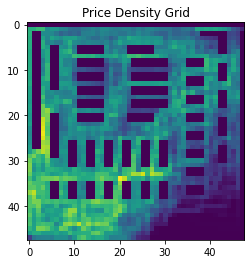

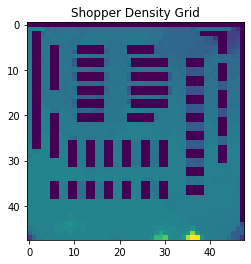

In [73]:
plt.imshow(price_density_grid)
plt.title("Price Density Grid")
plt.show()

plt.imshow(shopper_density_grid)
plt.title("Shopper Density Grid")
plt.show()

### Analysis of Crowd Density

In [74]:
total=0
for pdt in pdt_list:
    total += pdt.discounted_price*pdt.qty
    
print("No of products:", len(pdt_list))
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))
print("Total Value", total)
print("Value of Goods bought",fig_1_layout_object.value_of_goods_bought )
print("Total Loss:", fig_1_layout_object.total_loss())

No of products: 1535
Number of products in layout: 0
Total Value 891784.6099999888
Value of Goods bought 891784.6099999875
Total Loss: 4278.5693555555645


In [75]:
print("Standard Deviation of Shopper Density:", np.std(shopper_density_grid, axis=(0,1)))
print("Standard Deviation of Price Density:", np.std(price_density_grid, axis=(0,1)))

Standard Deviation of Shopper Density: 9.296725054553843
Standard Deviation of Price Density: 314.9606771881934


### Debugging Cells

In [76]:
for pdt in fig_1_layout_object.pdt_list:
    print(pdt.index)

In [77]:
for shelf in fig_1_layout_object.shelf_list:
    print (shelf.pdt_set)

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set(

In [78]:
for pdt in pdt_list:
    if pdt.index == 78:
        print(pdt.department)

Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
